In [45]:
#getting our own spotify data

In [46]:
#importing libraries
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
from skimage import io


In [47]:
#Authentication - without user using Spotify's Web API and making a new spotify developer account 
client_credentials_manager = SpotifyClientCredentials(
    client_id="14ab08163a0649be865dc476a3076fd7", client_secret="0ce7157e93604e008992ec4db58d8e70")
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [52]:
#Getting user playlist
playlist_link = input("Enter your playlist link: ")
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
playlist_URI = playlist_link.split("/")[-1].split("?")[0]
track_uris = [x["track"]["uri"] for x in sp.playlist_tracks(playlist_URI)["items"]]


In [59]:
print(track_uris)

[['spotify:track:2SHnUyZq0zwmvRIl4WY77G', 'spotify:track:6h5PAsRni4IRlxWr6uDPTP', 'spotify:track:0ct6r3EGTcMLPtrXHDvVjc', 'spotify:track:4ywUcVneBL8TNHIq6oJBz2', 'spotify:track:46lFttIf5hnUZMGvjK0Wxo', 'spotify:track:2V65y3PX4DkRhy1djlxd9p', 'spotify:track:4J7CKHCF3mdL4diUsmW8lq', 'spotify:track:1nas007nDbzLwDGwvMdz79', 'spotify:track:2PZFDozX54B0p7uUE3P4K7', 'spotify:track:5M9jOReAKGZ2AttVefFjTY', 'spotify:track:77TT8Xvx637TpzV8kKGkUw', 'spotify:track:4356Typ82hUiFAynbLYbPn', 'spotify:track:5QjJgPU8AJeickx34f7on6', 'spotify:track:5tf1VVWniHgryyumXyJM7w', 'spotify:track:2ISSQPb9LHHiV6ng2NXosL', 'spotify:track:7BKLCZ1jbUBVqRi2FVlTVw', 'spotify:track:6YUTL4dYpB9xZO5qExPf05', 'spotify:track:5vQIaNoKsT4xkG1j2KFBFs', 'spotify:track:591nHHHzZl1NLt9PMKpinM', 'spotify:track:698ItKASDavgwZ3WjaWjtz', 'spotify:track:6vWk151OrbHfKe4D6Z6tdV', 'spotify:track:3EmmCZoqpWOTY1g2GBwJoR', 'spotify:track:2eCjFwE5fwXttf6knCgX91', 'spotify:track:1YDJ2f1JuKzYWZpRYiBYHu', 'spotify:track:1tAutlhI9FwnKn7fVgmd5P'

In [53]:
images = []
for i in range(len(track_uris)):
    track = sp.track(track_uris[i])
    images.append(track["album"]["images"][0]["url"])


AttributeError: 'list' object has no attribute 'split'

In [50]:
#Acosticness confidence measure from 0.0 to 1.0 of whether the track is acoustic.
#Danceability measure describes how suitable a track is for dancing.
#duration_ms is the duration of the song track in milliseconds.
#Energy represents a perceptual measure of intensity and activity.
#Instrumentalness predicts whether a track contains vocals or not.
#Loudness of a track in decibels(dB).
#Liveness detects the presence of an audience in the recording.
#Speechiness detects the presence of spoken words in a track
#Time_signature is an estimated overall time signature of a track.
#Key the track is in. Integers map to pitches using standard Pitch Class notation.
#Valence measures from 0.0 to 1.0 describing the musical positiveness conveyed by a track.
#Target value describes the encoded value of 0 and 1. 0 means listener has not saved the song and 1 means listener have saved the song.
#Tempo is in beats per minute(BPM).
#Mode indicates the modality(major or minor) of the song.
#Song_title is the name of the song.
#Artist is the singer of the song.
#URL is the link to the song.



In [51]:
#making a new csv file with th data and headers as the features of the audio features and also Song Name and Artist Name
song_name = []
artist_name = []
acousticness = []
danceability = []
duration_ms = []
energy = []
instrumentalness = []
loudness = []
liveness=[]
speechiness = []
time_signature = []
key = []
valence = []
tempo = []
mode = []
target = []
url = []
#get track name and artist name
for track_uri in track_uris:
    track = sp.track(track_uri)
    song_name.append(track["name"])
    artist_name.append(track["artists"][0]["name"])
    audio_features = sp.audio_features(track_uri)
    acousticness.append(audio_features[0]["acousticness"])
    danceability.append(audio_features[0]["danceability"])
    duration_ms.append(audio_features[0]["duration_ms"])
    energy.append(audio_features[0]["energy"])
    instrumentalness.append(audio_features[0]["instrumentalness"])
    loudness.append(audio_features[0]["loudness"])
    liveness.append(audio_features[0]["liveness"])
    speechiness.append(audio_features[0]["speechiness"])
    time_signature.append(audio_features[0]["time_signature"])
    key.append(audio_features[0]["key"])
    valence.append(audio_features[0]["valence"])
    tempo.append(audio_features[0]["tempo"])
    mode.append(audio_features[0]["mode"])
    target.append(1)
    url.append(track["external_urls"]["spotify"])
#make a csv file with the data
df = pd.DataFrame({'Song Name':song_name, 'Artist Name':artist_name, 'Acousticness':acousticness, 'Danceability':danceability, 'Duration_ms':duration_ms, 'Energy':energy, 'Instrumentalness':instrumentalness, 'Loudness':loudness,'Liveness':liveness ,'Speechiness':speechiness, 'Time_signature':time_signature, 'Key':key, 'Valence':valence, 'Tempo':tempo, 'Mode':mode, 'Target':target, 'URL':url, 'Image':images})
df.to_csv('audio_features.csv', index=False)


AttributeError: 'list' object has no attribute 'split'

In [ ]:
df = pd.read_csv("Audio_features.csv")
df.head()

,Song Name,Artist Name,Acousticness,Danceability,Duration_ms,Energy,Instrumentalness,Loudness,Liveness,Speechiness,Time_signature,Key,Valence,Tempo,Mode,Target,URL,Image
0,Tumbling Dice,The Rolling Stones,0.500000,0.615,226333,0.910,0.511000,-4.248,0.281,0.0347,4,11,0.770,111.013,1,1,https://open.spotify.com/track/4hq0S6wznq7SHDy...,https://i.scdn.co/image/ab67616d0000b273ba42bf...
1,Wish You Were Here,Pink Floyd,0.735000,0.481,334744,0.262,0.011400,-15.730,0.832,0.0414,4,7,0.375,122.861,1,1,https://open.spotify.com/track/6mFkJmJqdDVQ1RE...,https://i.scdn.co/image/ab67616d0000b2731a84d7...
2,Smells Like Teen Spirit,Nirvana,0.000025,0.502,301920,0.912,0.000173,-4.556,0.106,0.0564,4,1,0.720,116.761,1,1,https://open.spotify.com/track/5ghIJDpPoe3CfHM...,https://i.scdn.co/image/ab67616d0000b273e175a1...
3,Paradise City,Guns N' Roses,0.016900,0.273,405640,0.952,0.011100,-8.762,0.142,0.0843,4,11,0.472,100.271,1,1,https://open.spotify.com/track/3YBZIN3rekqsKxb...,https://i.scdn.co/image/ab67616d0000b27368384d...
4,Another One Bites The Dust - Remastered 2011,Queen,0.112000,0.933,214653,0.528,0.329000,-6.472,0.163,0.1620,4,5,0.756,109.975,0,1,https://open.spotify.com/track/57JVGBtBLCfHw2m...,https://i.scdn.co/image/ab67616d0000b27307744e...


In [ ]:
from sklearn.preprocessing import MinMaxScaler
feature_cols = ['Acousticness', 'Danceability', 'Duration_ms', 'Energy',
                'Instrumentalness', 'Key', 'Liveness', 'Loudness', 'Mode',
                'Speechiness', 'Tempo', 'Time_signature', 'Valence', ]

scaler = MinMaxScaler()
normalized_df = scaler.fit_transform(df[feature_cols])

print(normalized_df[:2])


[[0.67112968 0.58431373 0.2782383  0.8918239  0.61124402 1.
  0.30857071 0.83541909 1.         0.02424242 0.29743689 1.
  0.78377173]
 [0.98657672 0.40915033 0.55272433 0.07672956 0.01363636 0.63636364
  1.         0.         1.         0.04189723 0.3857408  1.
  0.34351315]]


In [ ]:
# Create a pandas series with song titles as indices and indices as series values
indices = pd.Series(df.index, index=df['Song Name']).drop_duplicates()

# Create cosine similarity matrix based on given matrix
cosine = cosine_similarity(normalized_df)


def generate_recommendation(song_title,limit_songs, model_type=cosine):
    """
    Purpose: Function for song recommendations 
    Inputs: song title and type of similarity model
    Output: Pandas series of recommended songs
    """
    # Get song indices
    index = indices[song_title]
    global song_image
    
    # Get list of songs for given songs
    score = list(enumerate(model_type[indices[song_title]]))
    # Sort the most similar songs
    similarity_score = sorted(score, key=lambda x: x[1], reverse=True)
    # Select the top-user input recommended songs
    similarity_score = similarity_score[1:limit_songs+1]
    top_songs_index = [i[0] for i in similarity_score]
    # Top user-input value recommended songs
    top_songs = df['Song Name'].iloc[top_songs_index]
    top_songs_artists = df['Artist Name'].iloc[top_songs_index]
    song_image=[df['Image'].iloc[i] for i in top_songs_index]
    result_frame=pd.DataFrame({'Song Name':top_songs, 'Artist Name':top_songs_artists})
    return result_frame
    


In [ ]:
#Print all the songs in the playlist
for i in range(len(song_name)):
    print(song_name[i],":",artist_name[i])


Tumbling Dice : The Rolling Stones
Wish You Were Here : Pink Floyd
Smells Like Teen Spirit : Nirvana
Paradise City : Guns N' Roses
Another One Bites The Dust - Remastered 2011 : Queen
Highway to Hell : AC/DC
I Love Rock 'N Roll : Joan Jett & The Blackhearts
Whole Lotta Love - 1990 Remaster : Led Zeppelin
Creep : Radiohead
Something In The Way : Nirvana
Dream On : Aerosmith
Livin' On A Prayer : Bon Jovi
Don't Stop Believin' : Journey
Seven Nation Army : The White Stripes
Hotel California - 2013 Remaster : Eagles
La Grange - 2005 Remaster : ZZ Top
Heroes - 2017 Remaster : David Bowie
Tom Sawyer : Rush
Baba O'Riley : The Who
Hold the Line : TOTO
Paranoid : Black Sabbath
Police & Thieves - Remastered : The Clash
Under the Bridge : Red Hot Chili Peppers
Back In Black : AC/DC
Everlong : Foo Fighters
(I Can't Get No) Satisfaction - Mono Version : The Rolling Stones
Paradise By the Dashboard Light : Meat Loaf
Dreams - 2004 Remaster : Fleetwood Mac
We Will Rock You - Remastered 2011 : Queen
Ent

In [ ]:
song_value=input("Write the song name you want to recommend from this playlist")

In [ ]:
number=int(input("Number of Recommended Songs you want to see"))  

In [ ]:
print("Recommended Songs:")
print(generate_recommendation(song_value,number,cosine))

Recommended Songs:
                          Song Name      Artist Name
62         Rock and Roll - Remaster     Led Zeppelin
45  One Way Or Another - Remastered          Blondie
74            Bitter Sweet Symphony        The Verve
68         All Along the Watchtower     Jimi Hendrix
76            White Wedding - Pt. 1       Billy Idol
64                           Zombie  The Cranberries
36                You Really Got Me        The Kinks
81              Sweet Child O' Mine    Guns N' Roses
42              Sweet Child O' Mine    Guns N' Roses
78             Carry on Wayward Son           Kansas


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\risha\\AppData\\Local\\Temp\\tmpzcqg96j1'

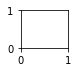

In [ ]:
#show all the images of the recommended songs
for i in range(len(song_image)):
    plt.subplot(len(song_image)//2,(len(song_image)//2)+1,i+1)
    image=io.imread(song_image[i])
    plt.imshow(image)
    plt.xlabel((song_name[i],":",artist_name[i]),size=10)
